## Internet of Things Traffic Prediction using RNN Models

In [36]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Import libraries for metrics and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [37]:
# Load the dataset
df = pd.read_csv("../dataset/esp32_1_data.csv")
df.head() # Display the first few rows of the dataset

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:13,28.3,81.5,0.242920,0.054,0.0,-61
1,2025-05-12 | 10:14:15,28.5,80.2,0.336914,0.054,0.0,-61
2,2025-05-12 | 10:14:17,28.5,80.2,0.206543,0.054,0.0,-62
3,2025-05-12 | 10:14:19,28.5,80.2,0.434326,0.054,0.0,-65
4,2025-05-12 | 10:14:21,28.5,80.2,0.428711,0.054,0.0,-55


### Data Preprocessing

In [38]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Set the timestamp as the index
df.set_index("timestamp", inplace=True)
df_resampled = df.resample("min").mean()

# Check the shape of the dataset
print(f"Shape of the dataset: {df_resampled.shape}")

# Check the missing values in the dataset
print(f"Missing values in the dataset:\n{df_resampled.isnull().sum()}")

Shape of the dataset: (1896, 6)
Missing values in the dataset:
temperature              117
humidity(%)              117
latency(ms)              117
throughput(bytes/sec)    117
packet_loss(%)           117
rssi(dBm)                117
dtype: int64


In [39]:
# Check the mean and standard deviation for each columns
print(f"Mean for each column\n{df_resampled.mean()}\n")
print(f"Standard deviation for each column\n{df_resampled.std()}\n")

# Check the amplitude for each column using the max and min values
print(f"Amplitude for each column\n{df_resampled.max() - df_resampled.min()}\n")

Mean for each column
temperature              30.909752
humidity(%)              74.027475
latency(ms)               0.277156
throughput(bytes/sec)     0.054000
packet_loss(%)            0.000000
rssi(dBm)               -57.561011
dtype: float64

Standard deviation for each column
temperature              8.457271e-01
humidity(%)              3.202931e+00
latency(ms)              2.120638e-02
throughput(bytes/sec)    2.020205e-17
packet_loss(%)           0.000000e+00
rssi(dBm)                1.431764e+00
dtype: float64

Amplitude for each column
temperature              4.152174e+00
humidity(%)              1.379421e+01
latency(ms)              2.098918e-01
throughput(bytes/sec)    1.387779e-17
packet_loss(%)           0.000000e+00
rssi(dBm)                8.648829e+00
dtype: float64



In [40]:
# Impute missing values using mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the missing values after imputation
print(f"Missing values after imputation:\n{df_resampled.isnull().sum()}")

Missing values after imputation:
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [41]:
# Show the data in 24 hours from 12:00:00 to 12:00:00
df_one_day_format = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]

# Check the data
df_one_day_format.head()

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
timestamp,,,,,,
2025-05-12 12:00:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:01:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:02:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:03:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:04:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011


C:\Users\Fadel\AppData\Local\Temp\ipykernel_360\781380651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_format["rolling_mean_rssi"] = df_one_day_format["rssi(dBm)"].rolling(window=5, min_periods=1).mean()
C:\Users\Fadel\AppData\Local\Temp\ipykernel_360\781380651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_format["rolling_std_rssi"] = df_one_day_format["rssi(dBm)"].rolling(window=5, min_periods=1).std()


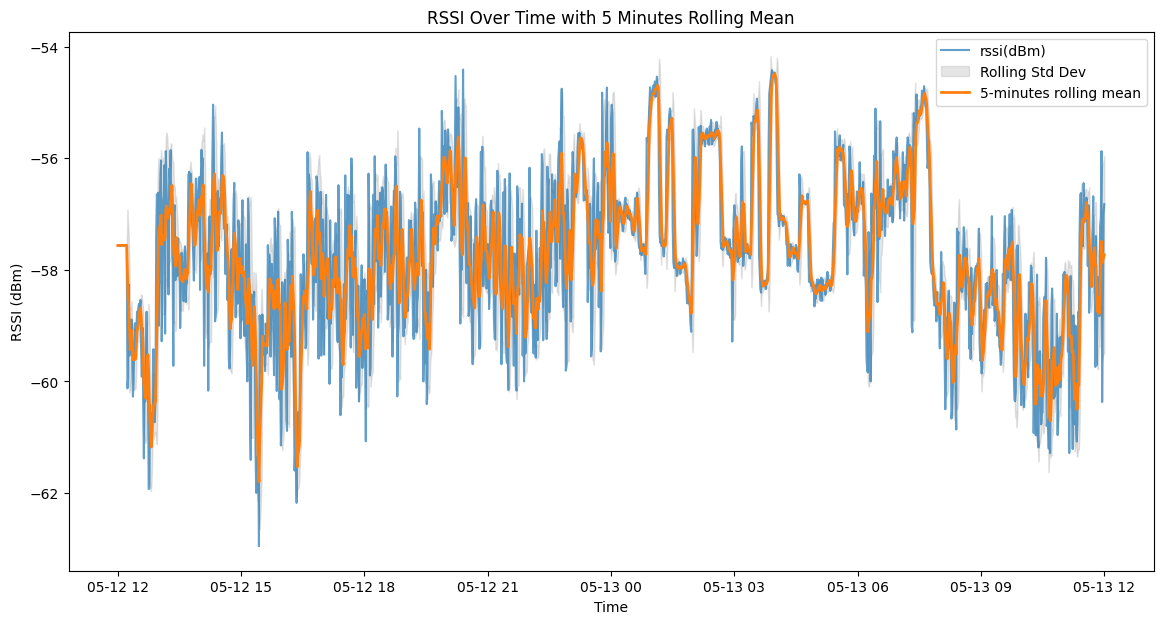

In [42]:
# Perform a rolling mean with a window of 15 minutes
df_one_day_format["rolling_mean_rssi"] = df_one_day_format["rssi(dBm)"].rolling(window=5, min_periods=1).mean()
df_one_day_format["rolling_std_rssi"] = df_one_day_format["rssi(dBm)"].rolling(window=5, min_periods=1).std()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_one_day_format.index, df_one_day_format["rssi(dBm)"], label="rssi(dBm)", alpha=0.7)
plt.fill_between(df_one_day_format.index, 
                 df_one_day_format["rolling_mean_rssi"] - df_one_day_format["rolling_std_rssi"], 
                 df_one_day_format["rolling_mean_rssi"] + df_one_day_format["rolling_std_rssi"], 
                 color='gray', alpha=0.2, label="Rolling Std Dev")
plt.plot(df_one_day_format.index, df_one_day_format["rolling_mean_rssi"], label="5-minutes rolling mean", linewidth=2)
plt.title("RSSI Over Time with 5 Minutes Rolling Mean")
plt.xlabel("Time")
plt.ylabel("RSSI (dBm)")
plt.legend()
plt.show()

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df.drop(columns=["rssi(dBm)"], axis=1)
y = df["rssi(dBm)"]

# Combine all data
full_data = pd.concat([X, y], axis=1)
full_data = full_data.dropna()

# Split into features and target variable again
X = full_data
y = full_data["rssi(dBm)"]

# Scale the data using MinMaxScaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scalers
X_scaled = feature_scaler.fit_transform(X)

# Convert 1D to 2D array, which -1 means "as many rows as needed and 1 means one column
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
  X_scaled, y_scaled, test_size=0.2,
  shuffle=False
)

### Data Visualization

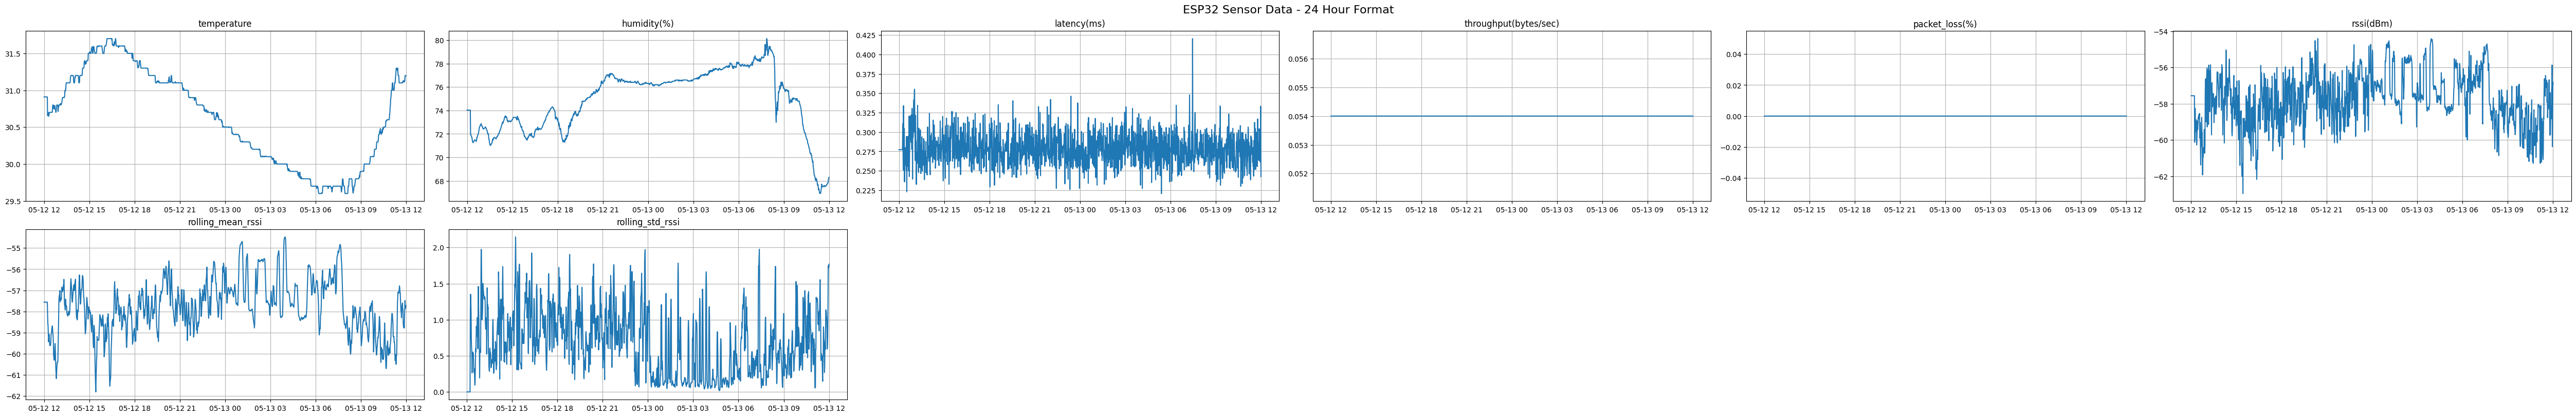

In [51]:
# Define num of rows and columns for the subplots
num_cols = 6
num_rows = int(np.ceil(len(df_one_day_format.columns) / num_cols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 8), constrained_layout=True)

# Flatten the axes array for iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(df_one_day_format.columns):
  axes[i].plot(df_one_day_format[column])
  axes[i].set_title(column)
  axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

# Set the overall title for the figure
fig.suptitle("ESP32 Sensor Data - 24 Hour Format", fontsize=16)
plt.show()

## LSTM Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=10, 
  restore_best_weights=True
)

# Model building
model_lstm = Sequential()
model_lstm.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Input layer
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(LSTM(units=32, return_sequences=False))
model_lstm.add(Dropout(0.2)) # Add dropout layer with 20% dropout rate
model_lstm.add(Dense(units=1))  # Output layer for regression

# Define optimizer
adam = Adam(learning_rate=0.001) 

# Compile the model
model_lstm.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])
model_lstm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 6, 16)          │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,457 (29.13 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model
history_lstm = model_lstm.fit(
  X_train.reshape(X_train.shape[0], X_train.shape[1], 1), # Reshape X_train for RNN input
  y_train.reshape(-1, 1), # Reshape y_train for RNN input
  epochs=5,
  callbacks=[early_stopping],
  validation_data=(
    X_test.reshape(X_test.shape[0], X_test.shape[1], 1), # Reshape X_test for RNN input
    y_test.reshape(-1, 1) # Reshape y_test for RNN input
  ),
  verbose=1
)

Epoch 1/5
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 107s 90ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 2/5
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 112s 94ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/5
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 109s 92ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 4.9519e-04 - val_mse: 4.9519e-04
Epoch 4/5
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 109s 92ms/step - loss: 9.6572e-04 - mse: 9.6572e-04 - val_loss: 1.1999e-04 - val_mse: 1.1999e-04
Epoch 5/5
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 109s 92ms/step - loss: 4.8421e-04 - mse: 4.8421e-04 - val_loss: 2.1805e-05 - val_mse: 2.1805e-05


### LSTM Model Predict

In [58]:
# Predict on the test set
predictions_lstm = model_lstm.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Inverse transform the predictions to get the actual values
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)

# Using y_test unscaled values for evaluation
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step


### Performance Metrics

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Define a list of model predictions and names for evaluation
metrics_list = []

# Calculate evaluation metrics
metrics_list.append({
    "Model": "LSTM",
    "MAE": mean_absolute_error(y_test_unscaled, predictions_lstm),
    "MSE": mean_squared_error(y_test_unscaled, predictions_lstm),
    "RMSE": np.sqrt(mean_squared_error(y_test_unscaled, predictions_lstm)),
    "R2": r2_score(y_test_unscaled, predictions_lstm),
    "MAPE": mean_absolute_percentage_error(y_test_unscaled, predictions_lstm)
})

metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Model,MAE,MSE,RMSE,R2,MAPE
0,LSTM,0.071352,0.01256,0.11207,0.99294,0.00126


### Visualize Results

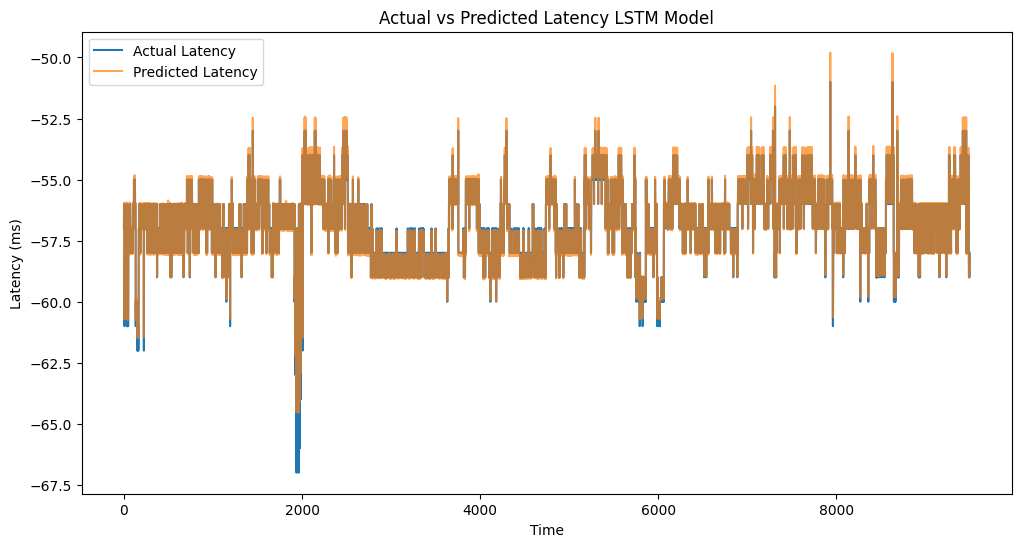

In [67]:
# Visualize the predictions for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Latency")
plt.plot(predictions_lstm, label="Predicted Latency", alpha=0.7)
plt.title("Actual vs Predicted Latency LSTM Model")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()